In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xesmf as xe
import cordex as cx
import cf_xarray as cfxr

/work/ch0636/g300047/.conda/envs/xesmf_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [11]:
# Hier das Ziel Gitter:
dm=cx.cordex_domain('AFR-22', bounds=True)
# Hier der Population file, welcher auf das Zielgitter afr-22 remapped werden soll (conservative)
pop = xr.open_dataset('/work/ch0636/g300047/cicles/population/org/population_ssp5soc_2.5min_annual_1861-2100.nc4',decode_times=False)
# reindex lat (-90 to 90) and reduce to region of interest
pop = pop.reindex(lat=pop['lat'][::-1]).sel(lon=slice(dm.lon.min(),dm.lon.max()),lat=slice(dm.lat.min(),dm.lat.max()))
# compute cell areas
src_area = xe.util.cell_area(pop)
tgt_area = xe.util.cell_area(dm)

In [12]:
# jetzt erstelle ich den regridder (so funktioniert es in Climate_fact_data (theoretisch)
%time regridder = xe.Regridder(pop, dm, method='conservative')

CPU times: user 1min 53s, sys: 1.98 s, total: 1min 54s
Wall time: 1min 55s


In [13]:
# könnte man durch dask beschleunigen
%time pop_regrid = regridder(pop / src_area) * tgt_area

/work/ch0636/g300047/.conda/envs/xesmf_env/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


CPU times: user 13.9 s, sys: 1min 3s, total: 1min 17s
Wall time: 1min 19s


In [15]:
#save pop_regrid to netcdf file
pop_regrid.to_netcdf(
	'/work/ch0636/g300047/cicles/population/org/population_ssp5soc_2.5min_annual_1861-2100_africa22.nc4',
	format='NETCDF4'
)

In [7]:
#pop_before = pop.isel(time=0)
total_before = pop['number_of_people'].isel(time=0).sum().item()
total_after = pop_regrid['number_of_people'].isel(time=0).sum().item()
total_before / total_after

0.9999998393554871

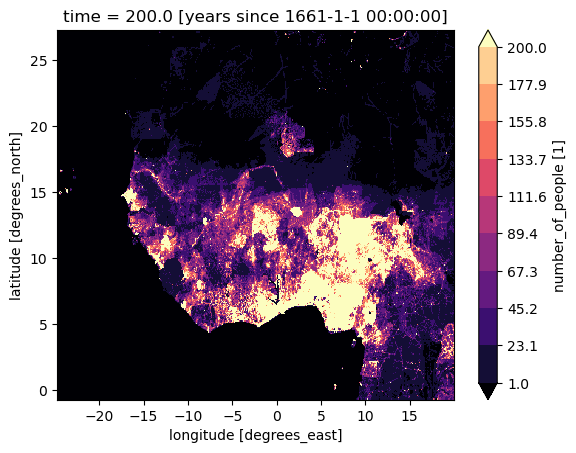

In [54]:
import matplotlib.colors as mcolors
import numpy as np
vmin = 1.0
vmax = 200.0
steps = 10
levels = np.linspace(vmin, vmax, steps)
 #west Afrika
            #lon : -25.87 to 20 by 0.11 degrees
            #lat : -0.75 to 27.3 by 0.11 degrees
pop_small = pop.sel(lon=slice(-25, 20), lat=slice(-0.75, 27.3))
pop_small['number_of_people'].isel(time=0).plot(cmap="magma", vmin=vmin, vmax=vmax, levels=levels)

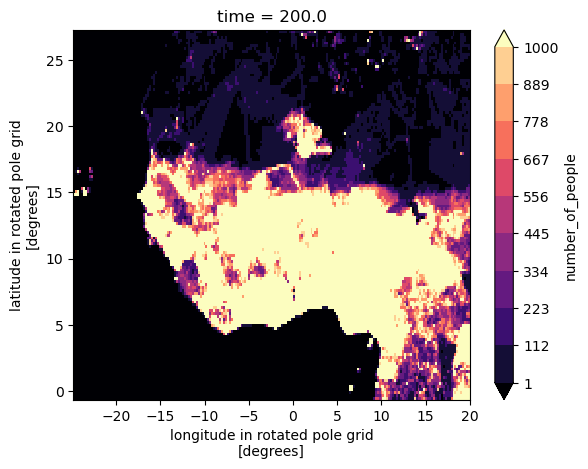

In [19]:
import numpy as np
vmin = 1.0
vmax = 1000.0
steps = 10
levels = np.linspace(vmin, vmax, steps)
pop_regrid_small = pop_regrid.sel(rlon=slice(-25, 20), rlat=slice(-0.75, 27.3))
pop_regrid_small['number_of_people'].isel(time=0).plot(cmap="magma", vmin=vmin, vmax=vmax, levels=levels)#1.e5,norm=mcolors.LogNorm())

In [ ]:
# hier plooten wir quasi die Bevölkerunsentwicklung, beides liegt genau übereinander, scheint also zu stimmen
pop_sum = pop_small['number_of_people'].sum(('lon', 'lat'))
pop_regrid_sum = pop_regrid_small['number_of_people'].sum(('rlon', 'rlat'))
xr.concat([pop_sum, pop_regrid_sum], dim=xr.DataArray(['original', 'regrid'], dims="source")).plot(hue='source')

In [68]:
pop1 = xr.open_dataset('/work/ch0636/g300047/cicles/population/population_ssp1soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=True)
pop1

<xarray.Dataset> Size: 302MB
Dimensions:           (time: 240, rlon: 388, rlat: 402)
Coordinates:
  * time              (time) float64 2kB 200.0 201.0 202.0 ... 437.0 438.0 439.0
  * rlon              (rlon) float64 3kB -24.75 -24.53 -24.31 ... 60.17 60.39
  * rlat              (rlat) float64 3kB -45.87 -45.65 -45.43 ... 42.13 42.35
    lon               (rlat, rlon) float64 1MB ...
    lat               (rlat, rlon) float64 1MB ...
Data variables:
    number_of_people  (time, rlat, rlon) float64 299MB ...
Attributes:
    regrid_method:  conservative

Text(0.5, 1.0, '1861-2100')

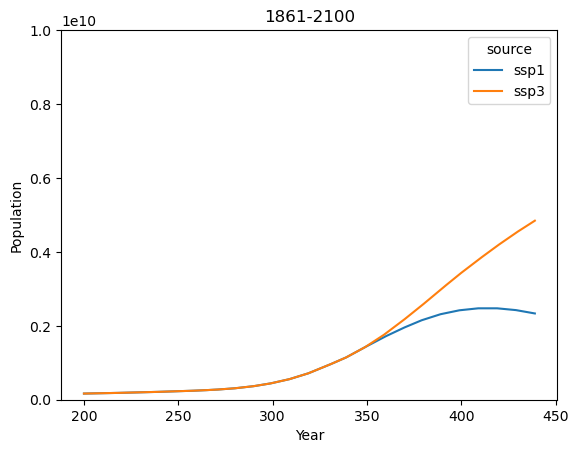

In [79]:
# hier plooten wir quasi die Bevölkerunsentwicklung, ssp1 // ssp3
pop1 = xr.open_dataset('/work/ch0636/g300047/cicles/population/population_ssp1soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
pop3 = xr.open_dataset('/work/ch0636/g300047/cicles/population/population_ssp3soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
pop_regrid_sum1 = pop1['number_of_people'].sum(('rlon', 'rlat'))
pop_regrid_sum3 = pop3['number_of_people'].sum(('rlon', 'rlat'))
import matplotlib.pyplot as plt

ax = xr.concat([pop_regrid_sum1, pop_regrid_sum3], dim=xr.DataArray(['ssp1', 'ssp3'], dims="source")).plot(hue='source')
plt.gca().set_xlabel('Year')

plt.gca().set_ylabel('Population')
plt.gca().set_ylim(0, 10000000000)
plt.gca().set_title('1861-2100')

Later try to make area mean:


In [24]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [31]:
import seaborn as sns
from format_data_tools import decode_time_pop
pop_dir = '/work/ch0636/g300047/cicles/population/org/'
# The population data got remapped to arf22 grid in a separate script
pop_ssp1 = xr.open_dataset(pop_dir+'/population_ssp1soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
pop_ssp3 = xr.open_dataset(pop_dir+'/population_ssp3soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
#time axis needs to be defined for the population data
pop_ssp1 = decode_time_pop(pop_ssp1)
pop_ssp3 = decode_time_pop(pop_ssp3)
pop_ssp1.time

<xarray.DataArray 'time' (time: 240)> Size: 2kB
array([cftime.DatetimeProlepticGregorian(1861, 1, 3, 11, 46, 56, 129032, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1862, 1, 3, 17, 46, 56, 129032, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1863, 1, 3, 23, 46, 56, 129032, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2098, 1, 4, 17, 46, 56, 129033, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2099, 1, 4, 23, 46, 56, 129033, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2100, 1, 5, 5, 46, 56, 129033, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2kB 1861-01-03 11:46:56.129032 ... 2100-01-05 05:4...

In [29]:
def sel_time_mean(ds, start, end):
    return ds.sel(time=slice(start, end)).mean(dim="time")

In [ ]:
#Calculate mean population
# 1991-2024 and  2031-2060
pop_1991_2024_ssp1 = sel_time_mean(pop_ssp1, "1991-01-01", "2024-12-31")
pop_2031_2060_ssp1 = sel_time_mean(pop_ssp1, "2031-01-01", "2060-12-31")
#diff_pop_ssp1 = pop_2031_2060_ssp1 - pop_1991_2024_ssp1
#Calculate mean population
# 1991-2024 and  2031-2060
pop_1991_2024_ssp3 = sel_time_mean(pop_ssp3, "1991-01-01", "2024-12-31")
pop_2031_2060_ssp3 = sel_time_mean(pop_ssp3, "2031-01-01", "2060-12-31")
#diff_pop_ssp3 = pop_2031_2060_ssp3 - pop_1991_2024_ssp3
